# State estimation from partial observation - Indirect Reconstruction

This notebook presents the possible solutions to reconstruct multi-physics fields from partial observation only: for instance, in a buoyancy-driven flow, we may only have access to temperature measurements, but we want to reconstruct the velocity field or in a nuclear reactor we have access to the temperature field but we want to reconstruct the neutron flux and the precursors fields. Two solutions are presented here: a two-step approach based on Parameter Estimation (PE) and POD with Interpolation, and a direct approach based on Gaussian Process Regression (GPR).

1. **Parameter Estimation + POD with Interpolation**: in this approach, snapshots from the observable fields are used to place sensors in the domain using the Generalized Empirical Interpolation Method (GEIM). Then, given a set of measurements, the parameters of the system are estimated using a least-square minimization. Finally, the full fields are reconstructed using POD with Interpolation (the procedure has been presented by [Introini et al. (2023)](https://www.sciencedirect.com/science/article/pii/S0306454922005680?via%3Dihub) and [Cammi et al. (2024)](https://www.sciencedirect.com/science/article/pii/S002954932400205X)).
2. **Gaussian Process Regression**: in this approach, sensors are placed with the GEIM method as well. Then, a GPR model is trained to learn the mapping between the measurements and the reduced coefficients of the POD modes of each field. Finally, given a set of measurements, the reduced coefficients are predicted using the GPR model and the full fields are reconstructed using the POD modes.

In this tutorial, you will learn:

- How to perform parameter estimation given a set of measurements using GEIM magic functions and sensors.
- How to reconstruct a field from partial observation using POD with Interpolation.
- How to reconstruct a field from partial observation using Gaussian Process Regression.

The data for this tutorial comes from a [ROM4FOAM](https://github.com/ERMETE-Lab/ROSE-ROM4FOAM) tutorial, the Buoyant Cavity (see [Introini et al. (2023)](https://doi.org/10.1016/j.anucene.2022.109538)). It is a steady-state simulation of a square cavity with a hot left wall and a cold right wall, leading to natural convection inside the cavity. The simulation is performed using OpenFOAM 2412: the results have been stored in an `npz` file.

## Import OpenFOAM cases from npz files

The data are parametric with respect to the Reynolds and Richardson number (Re and Ri, respectively). The snapshots of velocity, pressure and temperature are stored in an `npz` file, which can be easily loaded using the `numpy` library. Each variable is stored as a 2D array, where each column represents a snapshot at a given parameter value, and each row represents a spatial point in the domain.

`FunctionsList` objects can be built directly from these matrices, specifying the spatial coordinates of the points in the domain.

Among the available variables, we will focus on the temperature field, which is generally easier to measure.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

_data = np.load('Datasets/BuoyantCavity_OF2412/buoyant_cavity.npz', allow_pickle=True)

parameters = _data['parameters']

from pyforce.tools.functions_list import FunctionsList
var_names = ['U', 'p', 'T']
dataset = {
    field: FunctionsList(snap_matrix = _data[field])
    for field in var_names
}

# Let us scale the temperature field to [0, 1]
_T = dataset['T'].return_matrix() - 300
dataset['T'] = FunctionsList(dataset['T'].fun_shape)
dataset['T'].build_from_matrix(_T)

# Extract mesh
import pyvista as pv
grid = pv.read('Datasets/BuoyantCavity_OF2412/mesh_cavity.vtk')

Before delving into the different techniques, let us split the data into train and test.

In [3]:
from pyforce.tools.functions_list import train_test_split

train_dataset, test_dataset = {}, {}

for field in var_names:
    train_params, test_params, train_dataset[field], test_dataset[field] = train_test_split(parameters, dataset[field], test_size=0.2, random_state=42)

## Parameter Estimation (PE)
In this section, sensors will be placed in the domain using the GEIM method and the test parameter will be estimated by solving a constrained optimization problem. Within constrained minimization of the discrepancy between the measurements and the GEIM reconstruction of the observable fields, the GEIM reduced coefficients are forced to be on a manifold map from the parameter space to the GEIM coefficients space.

In [4]:
field_i_observed = 2

### Offline Phase: GEIM
This method has already been presented in the previous tutorial, so we will not go into details here. Only the observable field is used to place sensors in the domain.

In [8]:
from pyforce.offline.geim import GEIM

geim_offline = GEIM(grid, varname=field, sensors_type='Gaussian')

# GEIM parameters
sens_params = {
    's': 0.025, # spread of the Gaussian kernels - hyperparameter to be tuned according to the physical system
    'xm_list': grid.cell_centers().points[::10].tolist() # optional (sampling every 10 points to speed up the process)
}

train_beta_geim_coeffs = geim_offline.fit(  train_dataset[var_names[field_i_observed]], 
                                            Mmax = 20, # max number of sensors
                                            sensor_params=sens_params,
                                            verbose=True # optional
                                            )[2]

Creating Gaussian Sensor Library: 100.000 / 100.00% - 0.000236 s/it


As said before, it is required to have a mapping from the parameter space to the GEIM coefficients space, to constrain the PE problem. It is required to be a `SurrogateModelWrapper` object, so that it can be used smoothly in the class `ParameterEstimation`.

In [9]:
from scipy.interpolate import LinearNDInterpolator
from pyforce.online.online_base import SurrogateModelWrapper
from sklearn.model_selection import train_test_split as sk_split

class SurrogateMap(SurrogateModelWrapper):
    def __init__(self):
        pass
    def fit(self, train_params, train_coeffs):

        self.p = train_params.shape[1]

        self._models = []
        for i in range(train_coeffs.shape[0]):
            model = LinearNDInterpolator(train_params, train_coeffs[i].reshape(-1, 1))
            self._models.append(model)

    def predict(self, test_params):

        if test_params.ndim == 1:
            test_params = test_params.reshape(-1, self.p)

        predictions = np.array([model(test_params).flatten() for model in self._models])
        return predictions

_train_surrogate_param, _val_surrogate_param, _train_beta_coeff, _val_beta_coeff = sk_split(train_params, train_beta_geim_coeffs.T,
                                                         test_size=0.2, random_state=42)
_train_beta_coeff = _train_beta_coeff.T
_val_beta_coeff = _val_beta_coeff.T


surrogate_model = SurrogateMap()
surrogate_model.fit(_train_surrogate_param, _train_beta_coeff)

Let us make a plot of the reduced coefficients $\beta_m$.

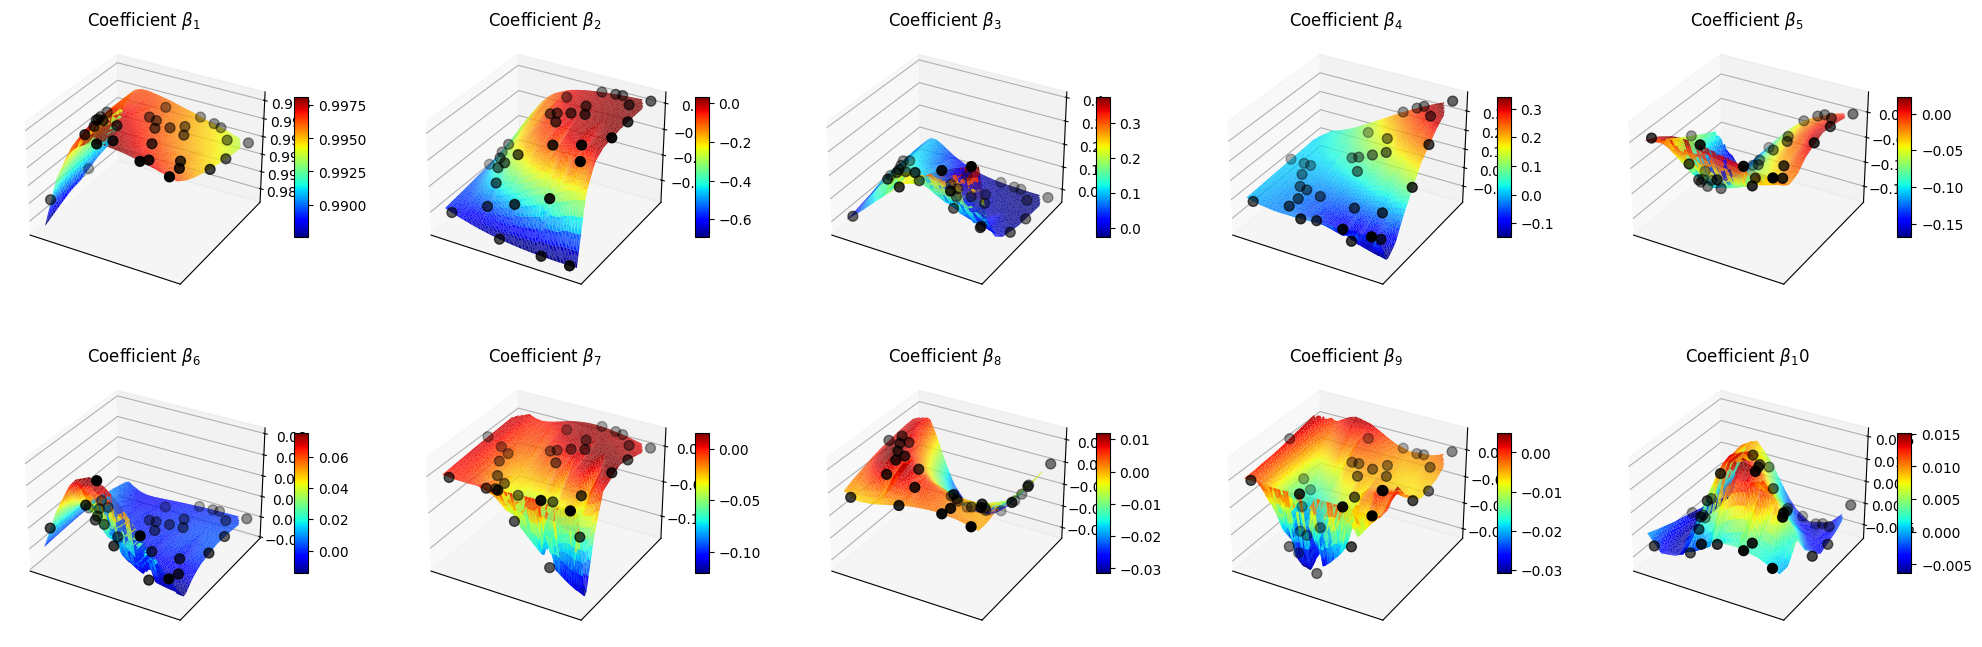

In [10]:
nrows = 2
ncols = 5

Replot = np.linspace(parameters[:,0].min(), parameters[:,0].max(), 100)
Riplot = np.linspace(parameters[:,1].min(), parameters[:,1].max(), 40)

Regrid, Rigrid = np.meshgrid(Replot, Riplot)
param_grid = np.array([Regrid.flatten(), Rigrid.flatten()]).T
predicted_beta_coeffs = surrogate_model.predict(param_grid)

fig, axs = plt.subplots(nrows, ncols, figsize=(5 * ncols, 4 * nrows), subplot_kw={'projection': '3d'})
axs = axs.flatten()

for ii in range(len(axs)):
    ax = axs[ii]
    X = param_grid[:, 0]
    Y = param_grid[:, 1]
    Z = predicted_beta_coeffs[ii]

    surf = ax.plot_trisurf(X, Y, Z, cmap='jet', edgecolor='none')
    ax.scatter(_val_surrogate_param[:,0], _val_surrogate_param[:,1], _val_beta_coeff[ii], color='k', s=50, label='Validation data')
    fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)
    ax.set_title(f'Coefficient $\\beta_{ii+1}$')
    
    ax.set_xticks([])
    ax.set_yticks([])

### Offline Phase: POD
For the unobservable fields, we will use POD to compress the spatial information and build appropriate surrogate models, for the relation between the parameters and the POD coefficients.

This class has already been presented in the previous tutorial, so we will not go into details here.

In [39]:
from pyforce.offline.pod import POD

pod_offline = dict()

for field in var_names:
    if field != var_names[field_i_observed]:
        pod_offline[field] = POD(grid, varname=field)
        pod_offline[field].fit(train_dataset[field], verbose=True)

Computing U correlation matrix: 160.000 / 160.00 - 0.008199 s/it
Eigenvalues calculated in 1.320022 seconds.
Computing p correlation matrix: 160.000 / 160.00 - 0.001661 s/it
Eigenvalues calculated in 0.269880 seconds.


Let us plot the eigenvalues of the POD modes for each field.

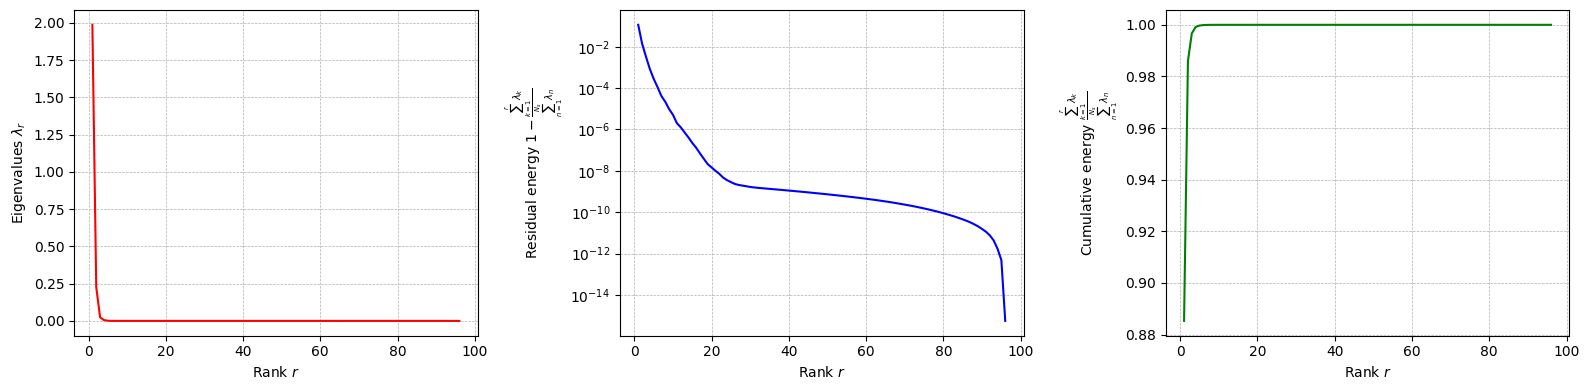

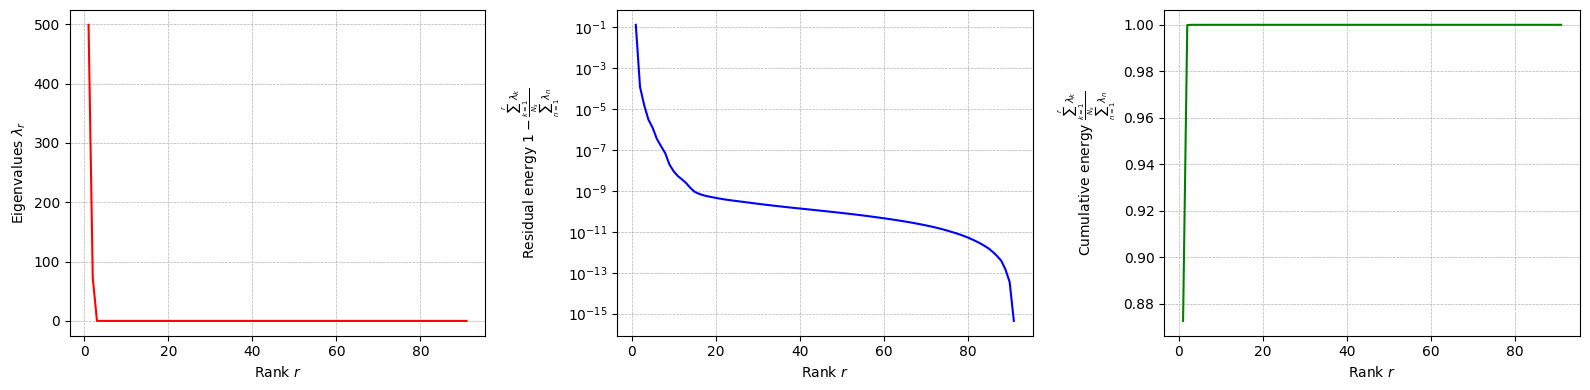

In [44]:
for field in pod_offline.keys():
    pod_offline[field].plot_eigenvalues()

Let us compute the POD modes for each field and the reduced coefficients

In [ ]:
pod_coeffs = dict()

for field in pod_offline.keys():
    pod_offline[field].compute_basis(train_dataset[field], rank=20)
    pod_coeffs[field] = pod_offline[field].reduce(train_dataset[field], N=20)

Let us now build the surrogate models for the POD coefficients of each unobservable field.

In [51]:
pod_surrogate_models = dict()
val_pod_coeff = dict()

for field in pod_offline.keys():
    _train_surrogate_param, _val_surrogate_param, _train_pod_coeff, _val_pod_coeff = sk_split(train_params, pod_coeffs[field].T,
                                                                                             test_size=0.2, random_state=42)
    _train_pod_coeff = _train_pod_coeff.T
    _val_pod_coeff = _val_pod_coeff.T
    val_pod_coeff[field] = _val_pod_coeff

    pod_surrogate_models[field] = SurrogateMap()
    pod_surrogate_models[field].fit(_train_surrogate_param, _train_pod_coeff)

Let us make some plots of the POD coefficients and the maps

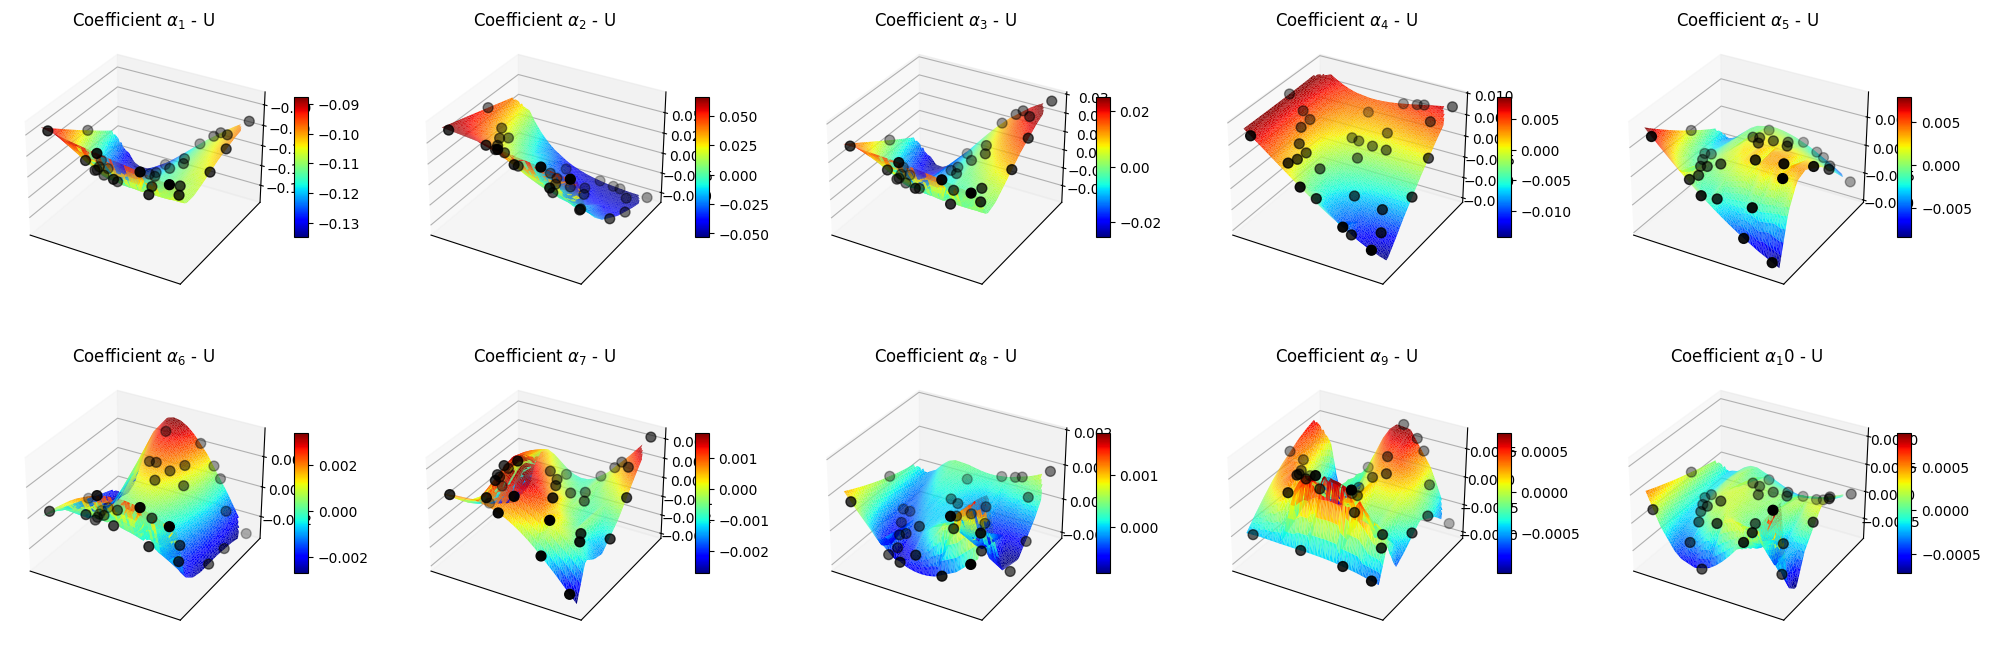

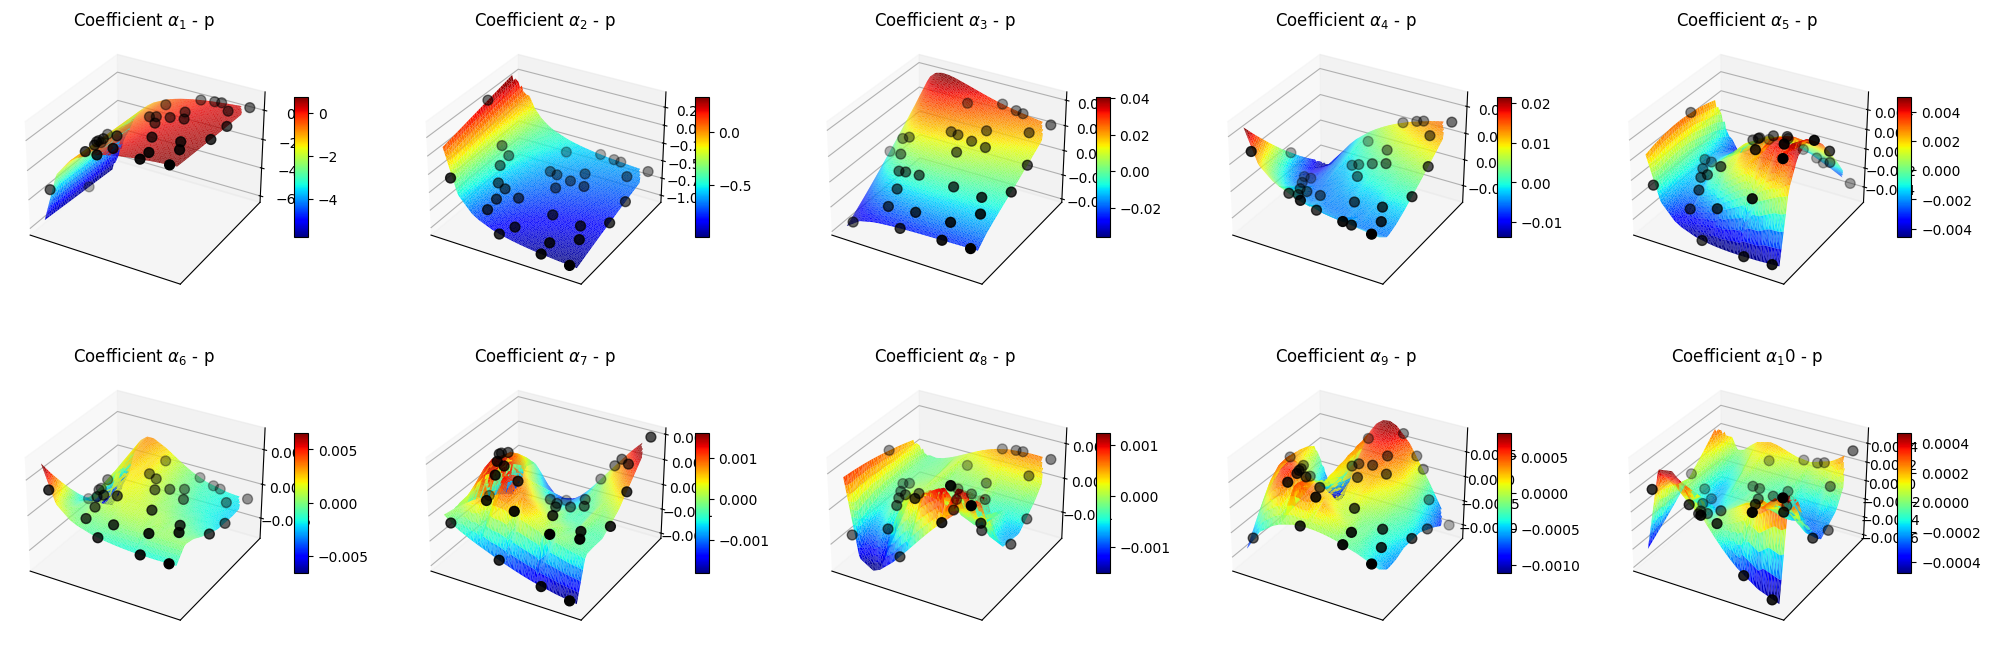

In [52]:
for field in pod_offline.keys():
    nrows = 2
    ncols = 5

    Replot = np.linspace(parameters[:,0].min(), parameters[:,0].max(), 100)
    Riplot = np.linspace(parameters[:,1].min(), parameters[:,1].max(), 40)

    Regrid, Rigrid = np.meshgrid(Replot, Riplot)
    param_grid = np.array([Regrid.flatten(), Rigrid.flatten()]).T
    predicted_beta_coeffs = pod_surrogate_models[field].predict(param_grid)

    fig, axs = plt.subplots(nrows, ncols, figsize=(5 * ncols, 4 * nrows), subplot_kw={'projection': '3d'})
    axs = axs.flatten()

    for ii in range(len(axs)):
        ax = axs[ii]
        X = param_grid[:, 0]
        Y = param_grid[:, 1]
        Z = predicted_beta_coeffs[ii]

        surf = ax.plot_trisurf(X, Y, Z, cmap='jet', edgecolor='none')
        ax.scatter(_val_surrogate_param[:,0], _val_surrogate_param[:,1], val_pod_coeff[field][ii], color='k', s=50, label='Validation data')
        fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)
        ax.set_title(f'Coefficient $\\alpha_{ii+1}$ - {field}')
        
        ax.set_xticks([])
        ax.set_yticks([])

    plt.show()

### Online Phase: Parameter Estimation
The `ParameterEstimation` class is used to perform the parameter estimation. The problem to solve is the following:

\begin{equation*}
\boldsymbol{\mu}^* = \underset{\boldsymbol{\mu} \in \mathcal{D}}{\mathrm{argmin}} \left\| \mathbf{y} - \mathbb{B} \boldsymbol{\beta}(\boldsymbol{\mu}) \right\|_2^2\qquad \text{s.t.}\quad \boldsymbol{\beta}(\boldsymbol{\mu}) = \mathcal{F}(\boldsymbol{\mu})
\end{equation*}

where $\mathbf{y}$ are the measurements, $\mathbb{B}$ is the matrix of the magic functions evaluated at the sensor locations, $\boldsymbol{\beta}(\boldsymbol{\mu})$ are the GEIM coefficients, and $\mathcal{F}(\boldsymbol{\mu})$ is the surrogate model mapping from the parameter space to the GEIM coefficients space.

The `ParameterEstimation` class requires the following inputs:
- `grid`: the mesh of the domain, as a `pyvista` object.
- `surrogate_model`: the surrogate model mapping from the parameter space to the GEIM coefficients space, as a `SurrogateModelWrapper` object.
- `bnds`: the bounds of the parameter space, as a list of tuples.

In [12]:
from pyforce.online.indirect_reconstruction import ParameterEstimation

bnds = [
    (parameters[:,0].min(), parameters[:,0].max()),
    (parameters[:,1].min(), parameters[:,1].max())
]

online_pe = ParameterEstimation(grid, surrogate_model, bnds)

At first, we have to load the magic functions and sensors from the GEIM offline phase. Then, compute the matrix $\mathbb{B}$.

In [13]:
online_pe.set_magic_functions(basis = geim_offline.magic_functions)
online_pe.set_magic_sensors(sensors = geim_offline.magic_sensors.library)
online_pe.compute_B_matrix()

Let us now compute the errors on the test set of the Parameter Estimation problem.

In [14]:
res = online_pe.compute_errors(test_param=test_params, test_snaps=test_dataset[var_names[field_i_observed]], 
                         M=20, verbose=True, use_brute=True, grid_elem=10, noise_std = 0.01)

Computing PE errors: 40.000 / 40.00 - 0.318632 s/it


Let us plot the errors and the estimated parameters versus the true parameters.

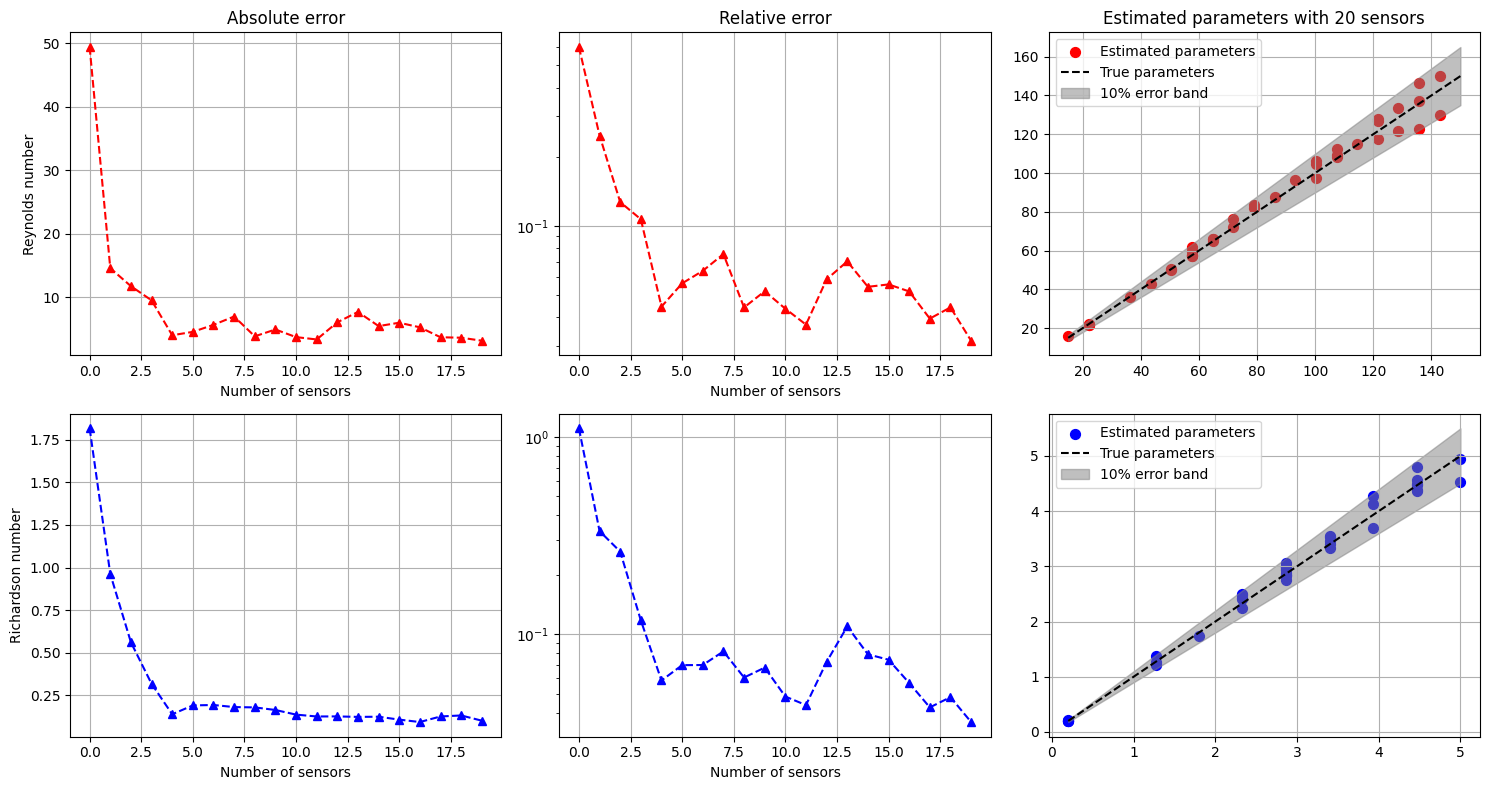

In [37]:
nrows = test_params.shape[1]
ncols = 3

colors = ['r', 'b']

fig, axs = plt.subplots(nrows, ncols, figsize=(5 * ncols, 4 * nrows))

for ii in range(nrows):
    for jj in range(ncols-1):
        axs[ii, jj].plot(res[jj][:, ii], '--^', color=colors[ii])

        if jj == 1:
            axs[ii, jj].set_yscale('log')

        axs[ii, jj].set_xlabel('Number of sensors')

axs[0, 0].set_title('Absolute error')
axs[0, 1].set_title('Relative error')

Mplot = 20
axs[0, 2].set_title(f'Estimated parameters with {Mplot} sensors')

axs[0, 0].set_ylabel(f'Reynolds number')
axs[1, 0].set_ylabel(f'Richardson number')

_param_plot = [np.linspace(parameters[:,0].min(), parameters[:,0].max(), 100),
               np.linspace(parameters[:,1].min(), parameters[:,1].max(), 100)]
for ii in range(nrows):
    axs[ii,-1].scatter(test_params[:,ii], res[3][:,Mplot-1, ii], color=colors[ii], s=50, label='Estimated parameters')
    axs[ii,-1].plot(_param_plot[ii], _param_plot[ii], 'k--', label='True parameters')
    axs[ii,-1].fill_between(_param_plot[ii], _param_plot[ii]*0.9, _param_plot[ii]*1.1, color='gray', alpha=0.5, label='10% error band')
    axs[ii,-1].legend()

for ax in axs.flatten():
    ax.grid()

plt.tight_layout()

### Online Phase: POD with Interpolation
Once the parameters have been estimated, the full fields can be reconstructed using POD with Interpolation.

In [ ]:
from pyforce.online.pod import POD as OnlinePOD

online_pod = dict()

for field in pod_offline.keys():
    online_pod[field] = OnlinePOD(grid, varname=field)
    online_pod[field].set_basis(pod_offline[field].pod_modes)

Let us estimate the full fields for the test set using the parameters estimated with 20 sensors.

In [58]:
mu_estimated = res[3][:, -1]

state_estimate = dict()

for field in pod_offline.keys():
    state_estimate[field] = online_pod[field].estimate(pod_surrogate_models[field], mu_estimated)

Let us make some contour plots of the estimated fields.

Text(0.5, 1.0, 'Residual')

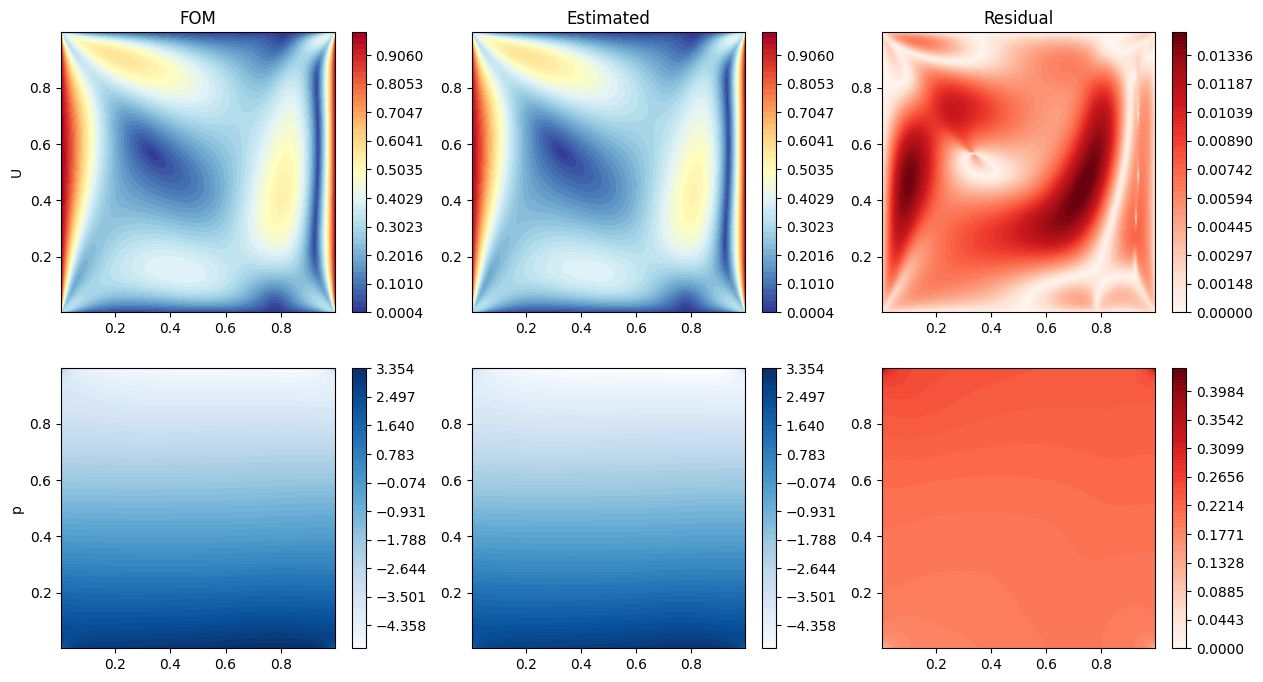

In [68]:
nodes = grid.cell_centers().points

mu_i_to_plot = 20

nrows = len(pod_offline.keys())
ncols = 3

cmaps = ['RdYlBu_r', 'Blues']

fig, axs = plt.subplots(nrows, ncols, figsize=(5 * ncols, 4 * nrows))

for ii, field in enumerate(pod_offline.keys()):

    if field == 'U':
        _fom = np.linalg.norm(test_dataset[field](mu_i_to_plot).reshape(-1, 3), axis=1)
        _est = np.linalg.norm(state_estimate[field][mu_i_to_plot].reshape(-1, 3), axis=1)
        _res = np.abs(_fom - _est)
    else:
        _fom = test_dataset[field](mu_i_to_plot) 
        _est = state_estimate[field][mu_i_to_plot]
        _res = np.abs(_fom - _est)

    levels = np.linspace(_fom.min(), _fom.max(), 50)
    
    c = axs[ii, 0].tricontourf(nodes[:,0], nodes[:,1], _fom, levels=levels, cmap=cmaps[ii])
    fig.colorbar(c, ax=axs[ii, 0])

    axs[ii, 1].tricontourf(nodes[:,0], nodes[:,1], _est, levels=levels, cmap=cmaps[ii])
    fig.colorbar(c, ax=axs[ii, 1])

    levels = np.linspace(0, _res.max(), 50)
    c = axs[ii, 2].tricontourf(nodes[:,0], nodes[:,1], _res, levels=levels, cmap='Reds')
    fig.colorbar(c, ax=axs[ii, 2])

    axs[ii, 0].set_ylabel(field)

axs[0,0].set_title(f'FOM')
axs[0,1].set_title(f'Estimated')
axs[0,2].set_title(f'Residual')

## Gaussian Process Regression (GPR) with POD
In this section, a more direct approach will be presented, based on Gaussian Process Regression (GPR). In this approach, sensors are placed in the domain using the GEIM method as well. Then, a GPR model is trained to learn the mapping between the measurements and the reduced coefficients of the POD modes of each field. Finally, given a set of measurements, the reduced coefficients are predicted using the GPR model and the full fields are reconstructed using the POD modes.

We are going to exploit the same offline phase as before, so we will not repeat it here.

Let us define the online class for geim to obtain noisy measurements

In [158]:
from pyforce.online.geim import GEIM

geim_online = GEIM(grid, varname=var_names[field_i_observed])
geim_online.set_basis(geim_offline.magic_functions)
geim_online.set_magic_sensors(geim_offline.magic_sensors.library)
geim_online.compute_B_matrix()

In [177]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from IPython.display import clear_output as clc

class SurrogateGPR(SurrogateModelWrapper):
    def __init__(self):
        pass
    def fit(self, train_params, train_coeffs, scale_data=True, alpha=1e-4, n_restarts_optimizer=5, 
            kernel = C(1.0, (1e-3, 1e3)) * RBF(length_scale=1.0, length_scale_bounds=(1e-4, 1e4)),
            **kwargs):

        # train_params shape (n_samples, n_params)
        # train_coeffs shape (n_samples, n_coeffs)

        if scale_data:
            self.input_scaler = MinMaxScaler()
            self.input_scaler.fit(train_params)

            self.output_scalers = MinMaxScaler()
            self.output_scalers.fit(train_coeffs)

        else:
            self.input_scaler = None
            self.output_scalers = None

        self.model = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=n_restarts_optimizer, alpha=alpha, **kwargs)

        _scaled_input = self.input_scaler.transform(train_params) if scale_data else train_params
        _scaled_output = self.output_scalers.transform(train_coeffs) if scale_data else train_coeffs
        self.model.fit(_scaled_input, _scaled_output)

    def predict(self, test_params):
        # test_params shape (n_test_samples, n_params)

        if self.input_scaler is not None:
            test_params = self.input_scaler.transform(test_params)

        predictions = self.model.predict(test_params)

        if self.output_scalers is not None:
            predictions = self.output_scalers.inverse_transform(predictions)

        return predictions.T # return shape (n_coeffs, n_test_samples)
    
    def predict_std(self, test_params):
        # test_params shape (n_test_samples, n_params)

        if self.input_scaler is not None:
            test_params = self.input_scaler.transform(test_params)
        
        _, std = self.model.predict(test_params, return_std=True)
        if self.output_scalers is not None:
            std = std * (self.output_scalers.data_max_ - self.output_scalers.data_min_)

        return std.T # return shape (n_coeffs, n_test_samples)

train_measures = geim_online.get_measurements(train_dataset[var_names[field_i_observed]], noise_std = 0.01).T

podgpr_surrogate_models = dict()
val_podgpr_meas = dict()
val_podgpr_coeff = dict()

for field in pod_offline.keys():

    train_idx, val_idx, _train_surrogate_param, _val_surrogate_param = sk_split(np.arange(train_params.shape[0]), train_params,
                                                                              test_size=0.2, random_state=42)
    _train_meas_gpr = train_measures[train_idx]
    val_podgpr_meas[field] = train_measures[val_idx]

    _train_pod_coeff = pod_coeffs[field][:, train_idx].T
    val_podgpr_coeff[field] = pod_coeffs[field][:, val_idx]

    # train GPR model
    kernel = C(1.0, (1e-3, 1e3)) * RBF(length_scale=1.0, length_scale_bounds=(1e-3, 1e3))
    podgpr_surrogate_models[field] = SurrogateGPR()
    podgpr_surrogate_models[field].fit(_train_meas_gpr, _train_pod_coeff, scale_data=True, kernel=kernel)

Let us compare the estimated parameters with the validation ones

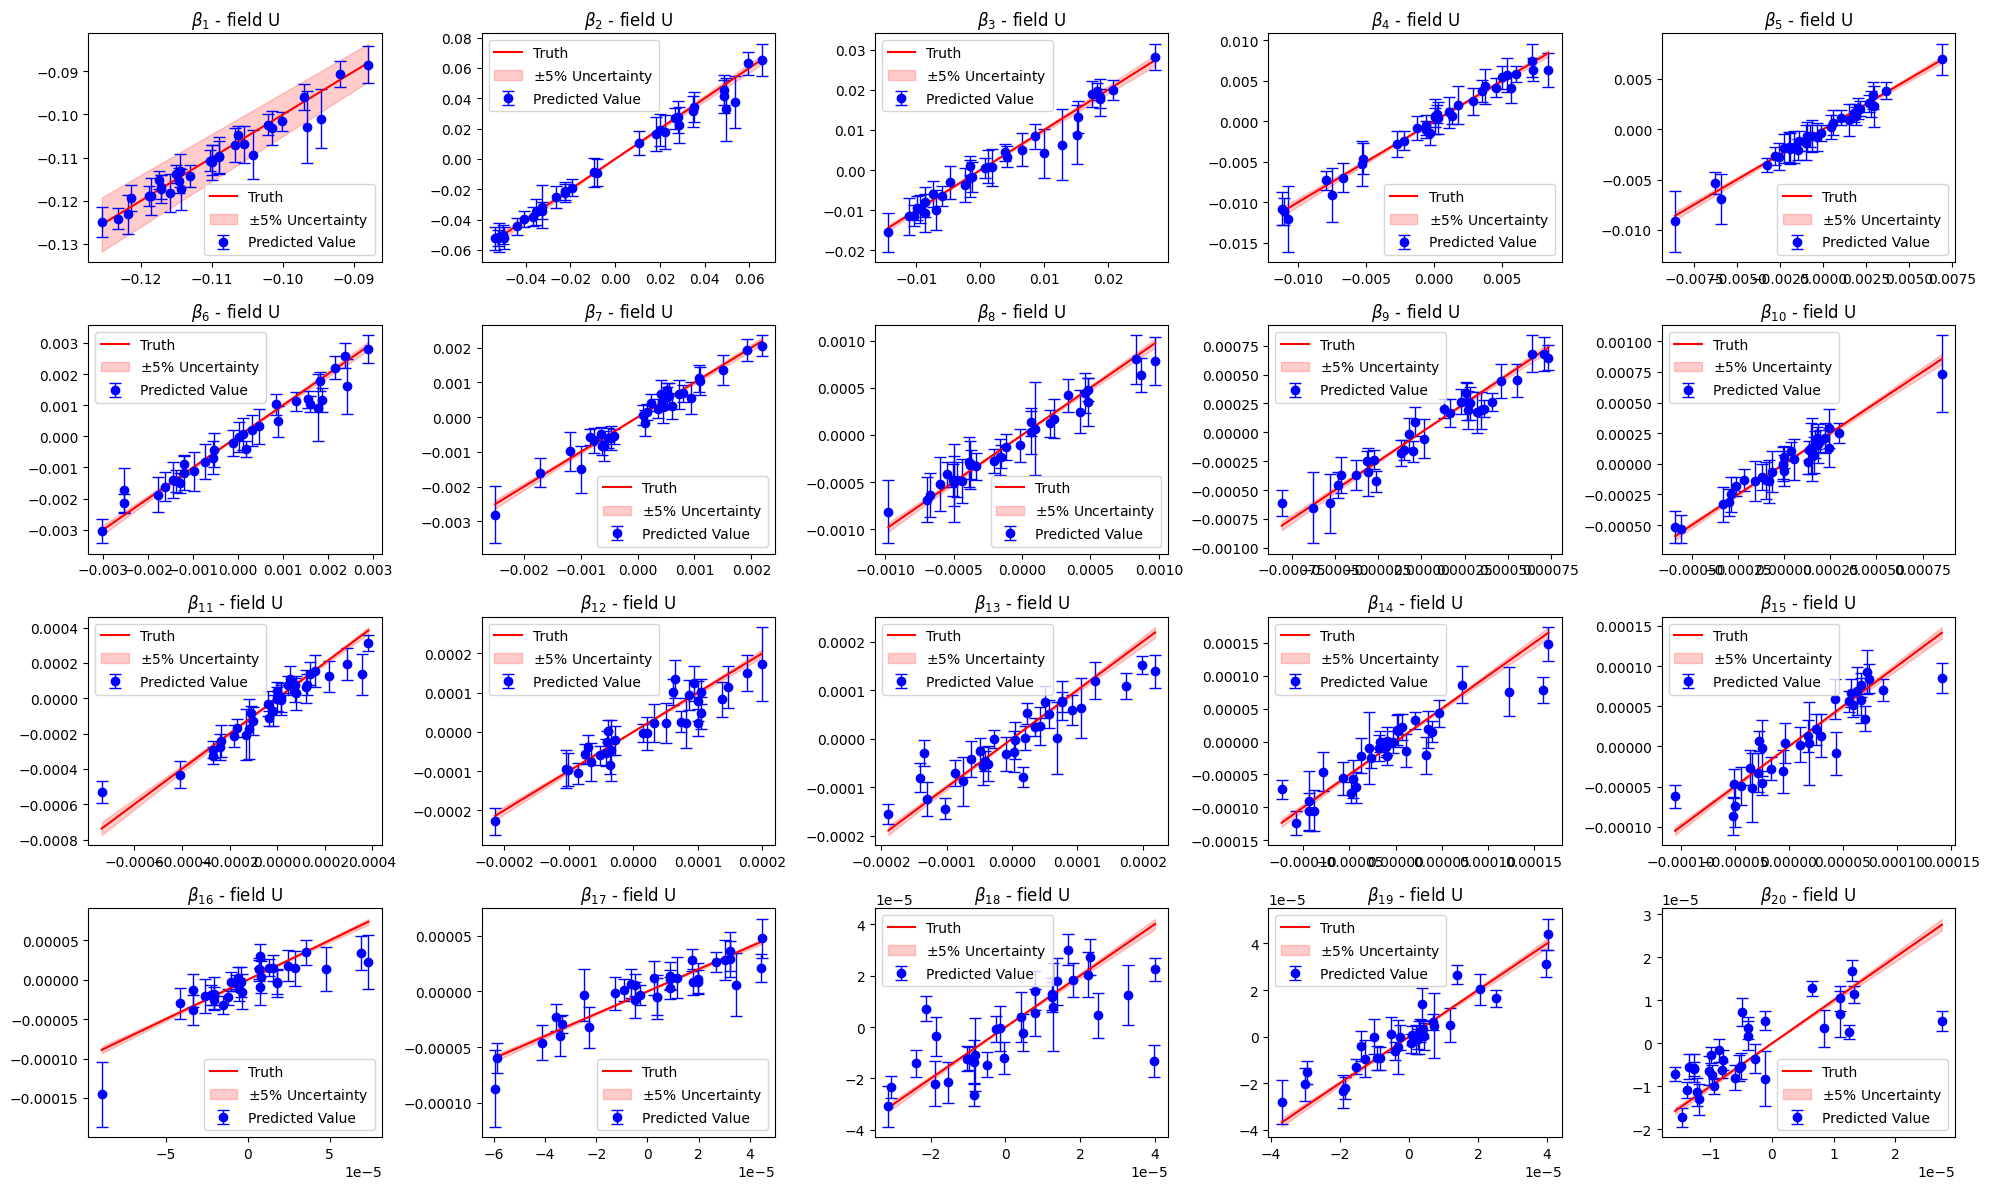

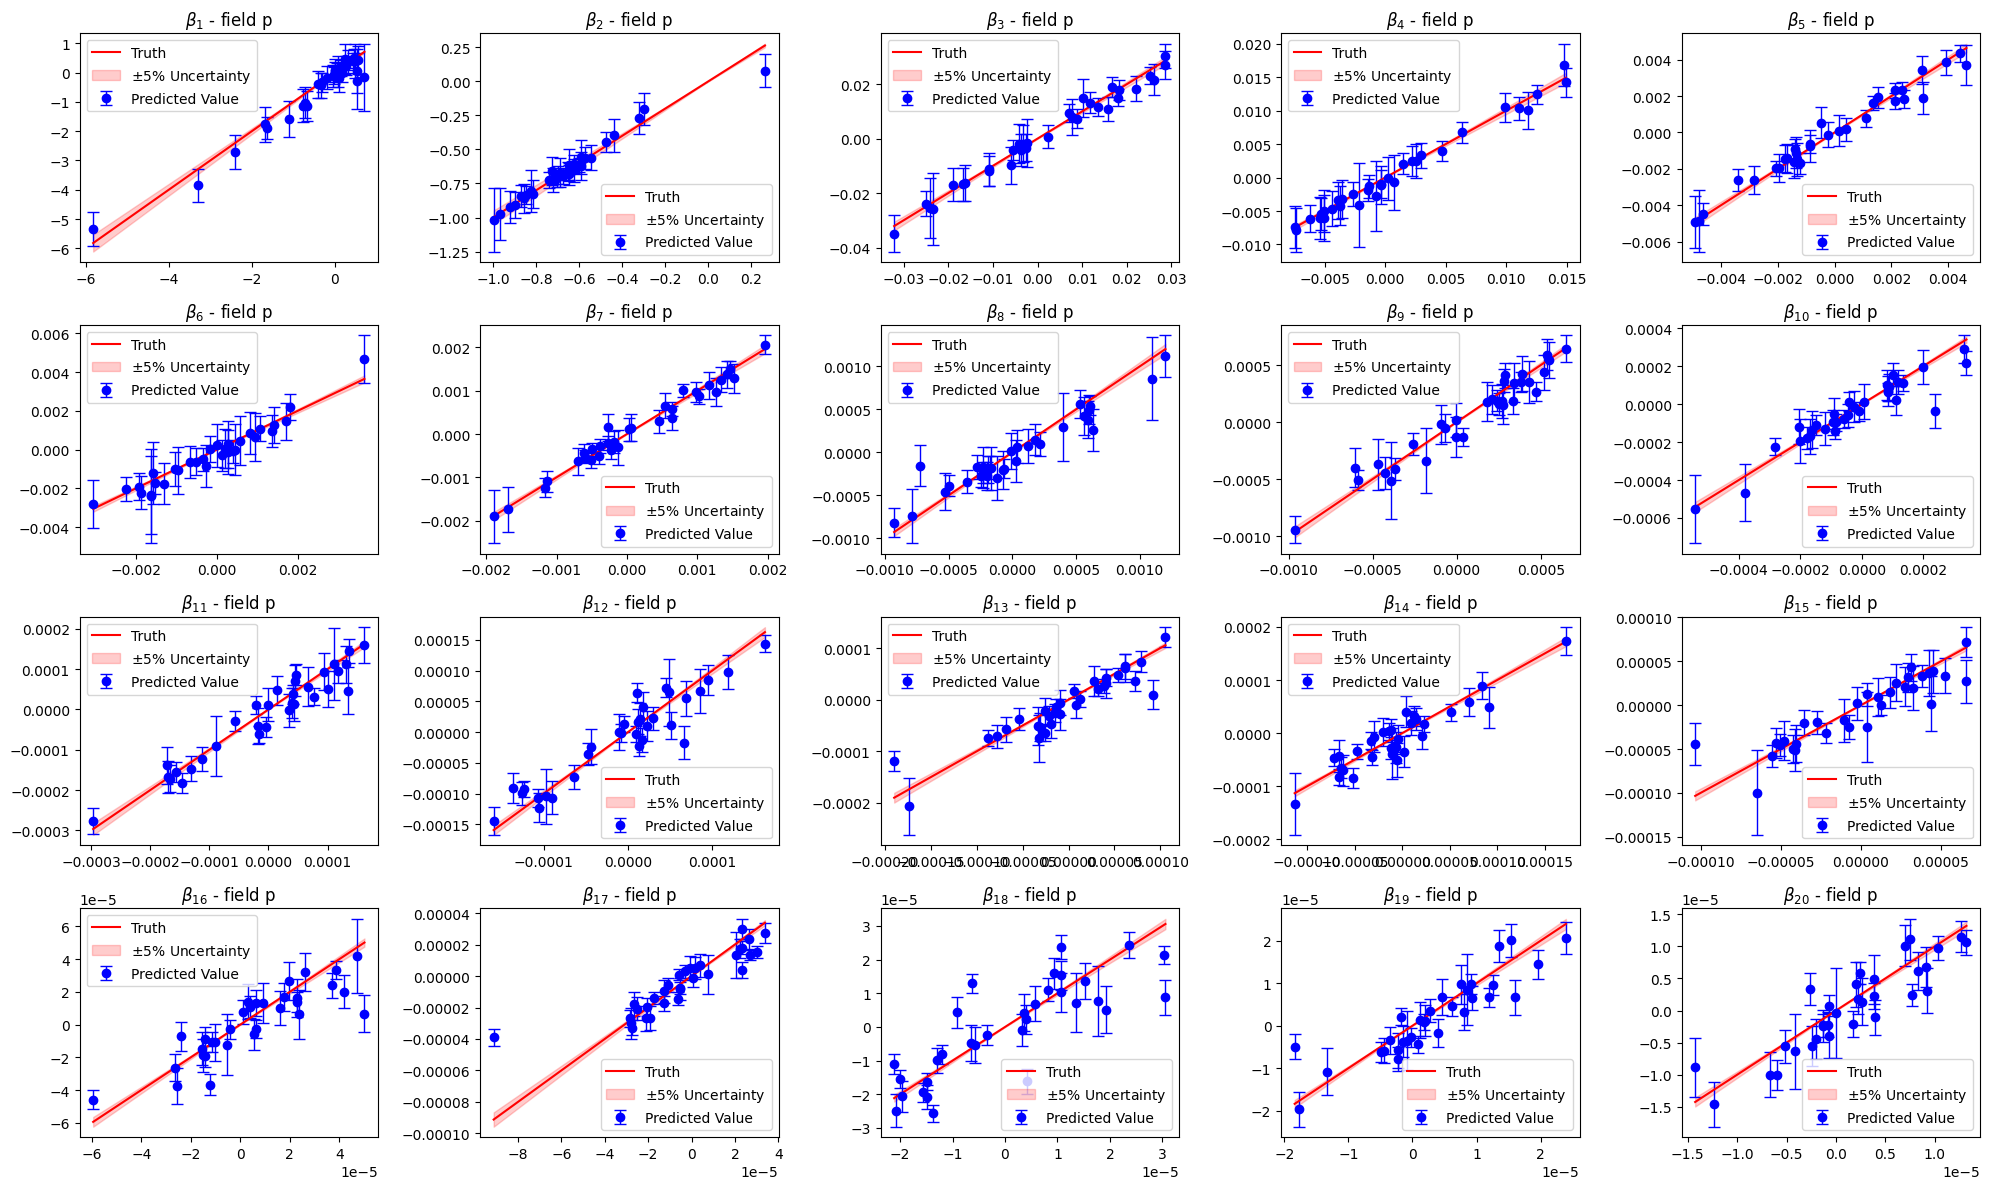

In [178]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning, module="sklearn.gaussian_process")

for field in pod_offline.keys():

    _estimated_beta = podgpr_surrogate_models[field].predict(val_podgpr_meas[field])
    _estimated_beta_std = podgpr_surrogate_models[field].predict_std(val_podgpr_meas[field])

    nrows = 4
    ncols = 5
    fig, axs = plt.subplots(nrows, ncols, figsize=(4 * ncols, 3 * nrows))
    axs = axs.flatten()

    for ii in range(nrows * ncols):

        axs[ii].errorbar(
            val_podgpr_coeff[field][ii],               # x-values (true coefficients)
            _estimated_beta[ii],                       # y-values (predicted coefficients)
            yerr=_estimated_beta_std[ii],              # error bars (std dev)
            fmt='o',                                   # marker style ('o' = circle)
            color='b',                                 # color of points and bars
            ecolor='blue',                        # color of error bars
            elinewidth=1.,                            # line thickness for error bars
            capsize=4,                                 # small horizontal caps on bars
            label='Predicted Value'
        )

        _line = np.linspace(val_podgpr_coeff[field][ii].min(), val_podgpr_coeff[field][ii].max(), 100)

        axs[ii].plot(_line, _line, 'r', label='Truth')
        axs[ii].fill_between(_line, _line * 0.95, _line * 1.05, color='r', alpha=0.2, label=r'$\pm 5\%$ Uncertainty')

        axs[ii].set_title(r'$\beta_{'+str(ii+1)+'}$ - field '+field)
        axs[ii].legend()
    plt.tight_layout()
    plt.show()

Let us now estimate the fields using this surrogate model

In [179]:
test_measures = geim_online.get_measurements(test_dataset[var_names[field_i_observed]], noise_std = 0.01).T

state_estimate = dict()

for field in pod_offline.keys():
    state_estimate[field] = online_pod[field].estimate(podgpr_surrogate_models[field], test_measures)

Let us make some contour plots of the estimation

Text(0.5, 1.0, 'Residual')

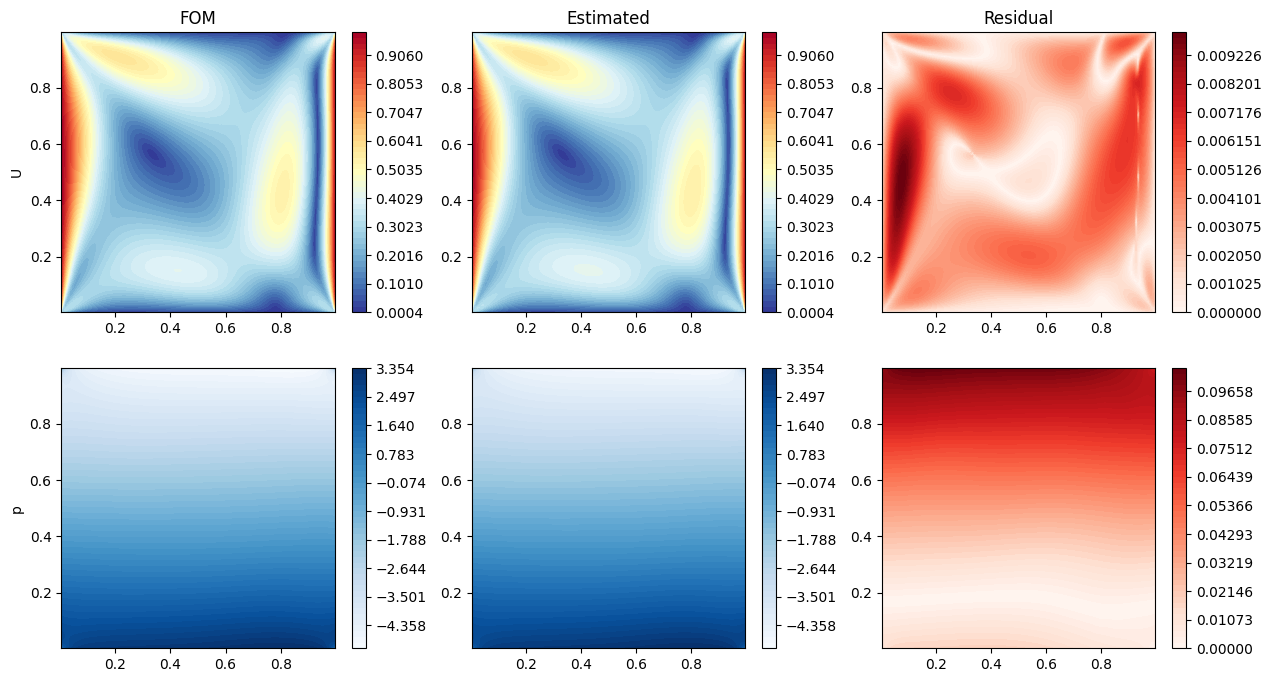

In [180]:
nodes = grid.cell_centers().points

mu_i_to_plot = 20

nrows = len(pod_offline.keys())
ncols = 3

cmaps = ['RdYlBu_r', 'Blues']

fig, axs = plt.subplots(nrows, ncols, figsize=(5 * ncols, 4 * nrows))

for ii, field in enumerate(pod_offline.keys()):

    if field == 'U':
        _fom = np.linalg.norm(test_dataset[field](mu_i_to_plot).reshape(-1, 3), axis=1)
        _est = np.linalg.norm(state_estimate[field][mu_i_to_plot].reshape(-1, 3), axis=1)
        _res = np.abs(_fom - _est)
    else:
        _fom = test_dataset[field](mu_i_to_plot) 
        _est = state_estimate[field][mu_i_to_plot]
        _res = np.abs(_fom - _est)

    levels = np.linspace(_fom.min(), _fom.max(), 50)
    
    c = axs[ii, 0].tricontourf(nodes[:,0], nodes[:,1], _fom, levels=levels, cmap=cmaps[ii])
    fig.colorbar(c, ax=axs[ii, 0])

    axs[ii, 1].tricontourf(nodes[:,0], nodes[:,1], _est, levels=levels, cmap=cmaps[ii])
    fig.colorbar(c, ax=axs[ii, 1])

    levels = np.linspace(0, _res.max(), 50)
    c = axs[ii, 2].tricontourf(nodes[:,0], nodes[:,1], _res, levels=levels, cmap='Reds')
    fig.colorbar(c, ax=axs[ii, 2])

    axs[ii, 0].set_ylabel(field)

axs[0,0].set_title(f'FOM')
axs[0,1].set_title(f'Estimated')
axs[0,2].set_title(f'Residual')